### Data analysis for DIA-NN's result on SC-Cycle dataset

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri
pandas2ri.activate()
numpy2ri.activate()

#### Check analysis time

In [2]:
report_dir = Path('../../reports/SC-Cycle')
with open(report_dir/'diann_220'/'report.log.txt') as f:
    lines = f.readlines()
    time_str = lines[-2].split(' ')[0][1:-1]
    total_minutes = int(time_str.split(':')[0]) + int(
        time_str.split(':')[-1]) / 60
    n = int(lines[-20].split(' ')[-2])
    t_mean = total_minutes / n
print(f'#runs: {n}, Minutes/Run: {t_mean:.2f}')

#runs: 229, Minutes/Run: 9.54


#### Check the report.parquet
1. #ids
2. miss rate

In [3]:
df_raw = pd.read_parquet(report_dir/'diann_220'/'report.parquet', engine='fastparquet')
n_pgs = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]['Protein.Group'].nunique()
n_prs = df_raw[df_raw['Global.Q.Value'] < 0.01]['Precursor.Id'].nunique()
print(f'Global n_pgs: {n_pgs}, Global n_prs: {n_prs}')

Global n_pgs: 3132, Global n_prs: 17067


In [4]:
df_raw['PG.Quantity'] = df_raw['PG.MaxLFQ'].values
df_raw = df_raw[~df_raw['Protein.Group'].str.contains(';')] # groups not in considering

# no local FDR filtering
df1 = df_raw[df_raw['Global.PG.Q.Value'] < 0.01]
df1 = df1[['Protein.Group', 'Run', 'PG.Quantity']]
df1 = df1.drop_duplicates().reset_index(drop=True)
df1 = df1.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df1.isna().sum().sum() / df1.shape[0] / df1.shape[1]
print(f'Only Global FDR filtering, shape: {df1.shape}, miss: {miss:.2f}')

# global & local FDR filtering
df2 = df_raw[(df_raw['Global.PG.Q.Value'] < 0.01) & (df_raw['PG.Q.Value'] < 0.01)]
df2 = df2[['Protein.Group', 'Run', 'PG.Quantity']]
df2 = df2.drop_duplicates().reset_index(drop=True)
df2 = df2.pivot(index='Protein.Group', columns='Run', values='PG.Quantity')
miss = df2.isna().sum().sum() / df2.shape[0] / df2.shape[1]
print(f'Local & Global FDR filtering, shape: {df2.shape}, miss: {miss:.2f}')
df2.columns.name = None
df2.index.name = None
df_protein = df2
df_protein.copy()

Only Global FDR filtering, shape: (3078, 229), miss: 0.48
Local & Global FDR filtering, shape: (3077, 229), miss: 0.53


,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_01_S3-G2_1_3873,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_02_S3-G3_1_3874,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_03_S3-G4_1_3875,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_04_S3-G5_1_3876,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_05_S3-G6_1_3877,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_06_S3-G7_1_3878,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_10_S3-G11_1_3882,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_11_S3-G12_1_3883,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_15_S3-H5_1_3888,20201009_TIMS04_Evo07_AnBr_1Cell_HeLa_NB_17_S3-H7_1_3890,...,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_86_S5-B2_1_4894,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_87_S5-B3_1_4895,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_88_S5-B4_1_4896,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_90_S5-B6_1_4898,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_92_S5-B8_1_4900,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_93_S5-B9_1_4901,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_94_S5-B10_1_4902,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_95_S5-B11_1_4903,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_96_S5-B12_1_4904,20201121_TIMS04_Evo07_SA_ADB_1cell_HeLa_G1_98_S5-C2_1_4906
A0AVT1,NaN,8768.788086,2412.275879,3414.790527,8830.140625,7916.306641,2240.763184,8246.836914,10532.092773,NaN,...,NaN,NaN,NaN,NaN,4695.673340,NaN,NaN,3295.76123,NaN,3563.727051
A0FGR8,NaN,NaN,1285.872559,NaN,6754.157227,NaN,NaN,3050.498779,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0MZ66,986.21228,NaN,NaN,NaN,3636.737793,1105.453369,NaN,1635.994995,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1X283,NaN,6739.654297,NaN,2519.188477,14270.836914,8968.746094,NaN,2788.783691,4566.275879,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3606.934326,NaN
A4D1P6,NaN,NaN,NaN,713.819275,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6M1,NaN,2476.926270,NaN,997.232971,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2396.010254
Q9Y6M5,NaN,NaN,NaN,NaN,6618.217773,2189.565918,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1838.30127,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6N5,NaN,NaN,NaN,1902.367310,3089.493896,9122.097656,2640.185791,4243.596191,2781.922607,2586.014648,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Q9Y6V0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,71038.273438,41246.824219,NaN,24519.613281,NaN,29898.876953,NaN,NaN,NaN


#### Convert to cell*protein matrix

In [5]:
df_meta = pd.DataFrame()
df_meta['sample_id'] = 'sample_' + df_raw['Run'].str.split('_').str[-1]
df_meta['treat_id'] = df_raw['Run'].str.split('_').str[-5]
assert set(df_meta['treat_id']) == set(['TB', 'G1', 'G2', 'NB'])
df_meta['treat_id'] = df_meta['treat_id'].replace({'NB': 'G2-M', 'TB': 'G1-S'})
df_meta = df_meta.drop_duplicates().reset_index(drop=True)
df_protein.columns = 'sample_' + df_protein.columns.str.split('_').str[-1]
df_sample = df_protein.T
df_sample = df_sample.merge(df_meta, left_index=True, right_on='sample_id')
df_sample = df_sample.reset_index(drop=True)
df_sample = df_sample[df_sample.columns[::-1]]
df_sample.copy()

,treat_id,sample_id,Q9Y6Y8,Q9Y6V0,Q9Y6N5,Q9Y6M5,Q9Y6M1,Q9Y6K9,Q9Y6K1,Q9Y6K0,...,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A4FU69,A4D1P6,A1X283,A0MZ66,A0FGR8,A0AVT1
0,G2-M,sample_3873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8783.376953,NaN,NaN,114662.359375,NaN,NaN,NaN,986.212280,NaN,NaN
1,G2-M,sample_3874,3732.786621,NaN,NaN,NaN,2476.926270,4903.024414,NaN,2460.546387,...,29474.822266,7511.246582,4116.859375,760070.750000,NaN,NaN,6739.654297,NaN,NaN,8768.788086
2,G2-M,sample_3875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2587.945557,1683.122314,229997.234375,6116.232422,NaN,NaN,NaN,1285.872559,2412.275879
3,G2-M,sample_3876,5401.528320,NaN,1902.367310,NaN,997.232971,1428.674805,NaN,NaN,...,24483.013672,4880.909180,2020.905518,501577.562500,NaN,713.819275,2519.188477,NaN,NaN,3414.790527
4,G2-M,sample_3877,10498.291992,NaN,3089.493896,6618.217773,NaN,5081.151367,NaN,5188.056152,...,40189.769531,12891.760742,3508.617920,996995.000000,NaN,NaN,14270.836914,3636.737793,6754.157227,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16832.080078,NaN,NaN,159546.593750,NaN,NaN,NaN,NaN,NaN,NaN
225,G1,sample_4902,NaN,29898.876953,NaN,NaN,NaN,NaN,NaN,NaN,...,27421.849609,NaN,NaN,90262.296875,NaN,NaN,NaN,NaN,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3087.101562,NaN,91296.968750,NaN,NaN,NaN,NaN,NaN,3295.761230
227,G1,sample_4904,NaN,NaN,NaN,NaN,NaN,NaN,22681.912109,NaN,...,22999.740234,3344.549316,NaN,178963.265625,NaN,NaN,3606.934326,NaN,NaN,NaN


#### Preprocess
1. drop the high-missingness proteins
2. impute
3. normalization
4. log-transformation

##### drop

In [6]:
cut_miss = 0.7
cols_pg = [col for col in df_sample.columns if not col.endswith('_id')]
cols_id = [col for col in df_sample.columns if col.endswith('_id')]
miss_ratio = df_sample[cols_pg].isna().mean()
cols_pg = miss_ratio[miss_ratio <= cut_miss].index.tolist()
df_sample = df_sample[cols_id + cols_pg]
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,NaN,NaN,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,NaN,NaN,2618.836182,8783.376953,NaN,NaN,114662.359375,NaN,NaN
1,G2-M,sample_3874,4903.024414,NaN,8166.291016,21388.742188,11790.070312,NaN,20707.763672,3476.234131,...,3806.568604,9669.978516,NaN,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,NaN,NaN,2594.709961,NaN,3915.852051,NaN,NaN,NaN,...,NaN,3852.014160,NaN,3527.628174,NaN,2587.945557,1683.122314,229997.234375,NaN,2412.275879
3,G2-M,sample_3876,1428.674805,NaN,6183.837402,10261.086914,11497.921875,NaN,6481.026855,NaN,...,NaN,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,NaN,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,NaN,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,NaN,NaN,3816.311768,NaN,4862.956543,NaN,NaN,NaN,...,NaN,3591.060791,NaN,NaN,16832.080078,NaN,NaN,159546.593750,NaN,NaN
225,G1,sample_4902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3559.323486,NaN,2429.979980,27421.849609,NaN,NaN,90262.296875,NaN,NaN
226,G1,sample_4903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3087.101562,NaN,91296.968750,NaN,3295.761230
227,G1,sample_4904,NaN,22681.912109,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4484.418945,NaN,NaN,22999.740234,3344.549316,NaN,178963.265625,3606.934326,NaN


##### impute

In [7]:
def impute(df):
    cols_X = df.columns[2:]
    protein_group = cols_X.to_list()
    sample_names = df['sample_id'].to_list()

    df_protein = df[cols_X].values.astype(float).T
    ro.globalenv["data_counts"] = df_protein
    ro.globalenv["protein_group"] = ro.StrVector(protein_group)
    ro.globalenv["sample_names"] = ro.StrVector(sample_names)

    r_script = """
        suppressPackageStartupMessages({
            library(pcaMethods)
        })

        data.mat <- as.matrix(data_counts)
        data.mat[is.nan(data.mat)] <- NA
        rownames(data.mat) <- protein_group
        colnames(data.mat) <- sample_names

        bpca.res <- pca(data.mat, method = "bpca")
        data.imputed <- completeObs(bpca.res)
        """
    ro.r(r_script)

    imputed_r = ro.r("data.imputed")
    imputed_np = np.array(imputed_r)
    imputed_np[imputed_np < 0] = 0
    df[cols_X] = imputed_np.T
    return df
df_sample = impute(df_sample)
df_sample.copy()

Step Number           :  10 
Increase in precision :  12.30884 
---------- 
Step Number           :  20 
Increase in precision :  2.423236e-05 
---------- 


,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,6094.767519,9233.388504,2605.813965,7076.818848,3119.607910,1513.860229,7382.763672,1352.692383,...,1658.716064,6554.816121,5963.587776,2618.836182,8783.376953,6228.241496,5931.633973,114662.359375,6165.464981,6119.245861
1,G2-M,sample_3874,4903.024414,22274.046663,8166.291016,21388.742188,11790.070312,3745.958682,20707.763672,3476.234131,...,3806.568604,9669.978516,966.130879,5616.848633,29474.822266,7511.246582,4116.859375,760070.750000,6739.654297,8768.788086
2,G2-M,sample_3875,4940.254258,7167.930269,2594.709961,7282.148204,3915.852051,4549.987416,7987.127611,6205.346665,...,4283.762789,3852.014160,4885.812052,3527.628174,13737.987025,2587.945557,1683.122314,229997.234375,4995.917032,2412.275879
3,G2-M,sample_3876,1428.674805,14975.488542,6183.837402,10261.086914,11497.921875,3926.240843,6481.026855,5869.087903,...,1605.373011,9810.929688,4957.241211,3618.535156,24483.013672,4880.909180,2020.905518,501577.562500,2519.188477,3414.790527
4,G2-M,sample_3877,5081.151367,31876.671915,15913.895508,22369.052734,10982.473633,7558.746582,23301.728516,15145.703125,...,3769.090576,11505.994141,4546.691899,10258.766602,40189.769531,12891.760742,3508.617920,996995.000000,14270.836914,8830.140625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,12905.822205,18520.234162,3816.311768,16659.106650,4862.956543,13434.681434,17069.727428,14337.584866,...,12368.534710,3591.060791,12671.010887,12715.426547,16832.080078,13146.330287,12614.979475,159546.593750,13032.264886,12950.531071
225,G1,sample_4902,14797.674019,18888.250730,15551.871072,17557.139722,15505.917883,15165.483452,17872.127575,15861.171514,...,14393.279847,3559.323486,14627.723914,2429.979980,27421.849609,14960.166487,14578.679318,90262.296875,14889.958542,14823.531382
226,G1,sample_4903,13208.064485,16826.815576,13871.094354,15626.713235,13866.876604,13549.303991,15891.047842,14130.478552,...,12862.027195,13738.166824,13056.694055,13085.606427,21160.350268,3087.101562,13020.750561,91296.968750,13289.559365,3295.761230
227,G1,sample_4904,12858.766568,22681.912109,13921.820852,16744.403946,13876.398368,13386.768547,17181.658501,14351.085378,...,12293.832301,4484.418945,12618.168575,12651.213356,22999.740234,3344.549316,12552.875236,178963.265625,3606.934326,12898.542238


##### normalize

In [8]:
X = df_sample[cols_pg].values
X = 10000 * X / X.sum(axis=1, keepdims=True)
df_sample[cols_pg] = X
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,3.370352,5.105981,1.440992,3.913417,1.725115,0.837151,4.082602,0.748027,...,0.917255,3.624755,3.297811,1.448193,4.857129,3.444162,3.280140,63.407258,3.409447,3.383888
1,G2-M,sample_3874,0.746251,3.390159,1.242928,3.255414,1.794475,0.570143,3.151767,0.529091,...,0.579368,1.471792,0.147047,0.854897,4.486133,1.143228,0.626595,115.684451,1.025790,1.334629
2,G2-M,sample_3875,2.165192,3.141528,1.137198,3.191587,1.716222,1.994148,3.500562,2.719651,...,1.877468,1.688243,2.141332,1.546073,6.021023,1.134233,0.737671,100.802147,2.189588,1.057241
3,G2-M,sample_3876,0.356811,3.740124,1.544412,2.562704,2.871603,0.980578,1.618635,1.465803,...,0.400941,2.450277,1.238070,0.903728,6.114626,1.219006,0.504721,125.268857,0.629167,0.852843
4,G2-M,sample_3877,0.555127,3.482594,1.738627,2.443866,1.199858,0.825809,2.545763,1.654700,...,0.411781,1.257054,0.496736,1.120792,4.390817,1.408452,0.383324,108.923809,1.559119,0.964712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,3.798562,5.451048,1.123252,4.903263,1.431311,3.954220,5.024121,4.219971,...,3.640422,1.056954,3.729450,3.742523,4.954174,3.869350,3.712958,46.959238,3.835777,3.811721
225,G1,sample_4902,4.415520,5.636119,4.640567,5.238925,4.626855,4.525272,5.332915,4.732860,...,4.294852,1.062077,4.364808,0.725089,8.182484,4.464007,4.350174,26.933623,4.443057,4.423236
226,G1,sample_4903,4.365734,5.561859,4.584888,5.165183,4.583494,4.478525,5.252555,4.670624,...,4.251356,4.540951,4.315700,4.325257,6.994246,1.020397,4.303820,30.176885,4.392671,1.089366
227,G1,sample_4904,3.770500,6.650883,4.082213,4.909863,4.068894,3.925323,5.038076,4.208084,...,3.604848,1.314940,3.699951,3.709641,6.744078,0.980702,3.680805,52.476340,1.057640,3.782163


##### log

In [9]:
df_sample[cols_pg] = np.log2(df_sample[cols_pg] + 1.)
df_sample.copy()

,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,2.127749,2.610223,1.287467,2.296727,1.446317,0.877470,2.345567,0.805727,...,0.939042,2.209377,2.103602,1.291717,2.550194,2.151911,2.097658,6.009151,2.140598,2.132211
1,G2-M,sample_3874,0.804261,2.134273,1.165383,2.089299,1.482577,0.650896,2.053726,0.612674,...,0.659348,1.305557,0.197925,0.891339,2.455790,1.099786,0.701855,6.866469,1.018485,1.223193
2,G2-M,sample_3875,1.662293,2.050163,1.095720,2.067497,1.441601,1.582145,2.170105,1.895167,...,1.524800,1.426664,1.651376,1.348274,2.811681,1.093718,0.797155,6.669624,1.673370,1.040711
3,G2-M,sample_3876,0.440220,2.244925,1.347332,1.832972,1.952931,0.985921,1.388815,1.302058,...,0.486397,1.786712,1.162255,0.928827,2.830788,1.149913,0.589496,6.980355,0.704134,0.889741
4,G2-M,sample_3877,0.637032,2.164334,1.453453,1.784029,1.137411,0.868536,1.826096,1.408549,...,0.497516,1.174441,0.581819,1.084603,2.430504,1.268106,0.468139,6.780360,1.355647,0.974317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,G1,sample_4901,2.262602,2.689533,1.086276,2.561513,1.281734,2.308658,2.590751,2.384042,...,2.214256,1.040510,2.241672,2.245655,2.573901,2.283729,2.236633,5.583737,2.273748,2.266553
225,G1,sample_4902,2.437100,2.730340,2.495840,2.641297,2.492329,2.466045,2.662870,2.519255,...,2.404590,1.044098,2.423527,0.786670,3.198884,2.449959,2.419586,4.803931,2.444417,2.439154
226,G1,sample_4903,2.423775,2.714105,2.481528,2.624144,2.481168,2.453788,2.644446,2.503508,...,2.392690,2.470134,2.410260,2.412851,2.998962,1.014638,2.407032,4.962405,2.431000,1.063065
227,G1,sample_4904,2.254141,2.935626,2.345457,2.563125,2.341671,2.300218,2.594089,2.380753,...,2.203153,1.210975,2.232646,2.235617,2.953093,0.986012,2.226757,5.740829,1.040991,2.257663


#### PCA
- calculating the silhouette score to check the separation

silhouette score: 0.1572


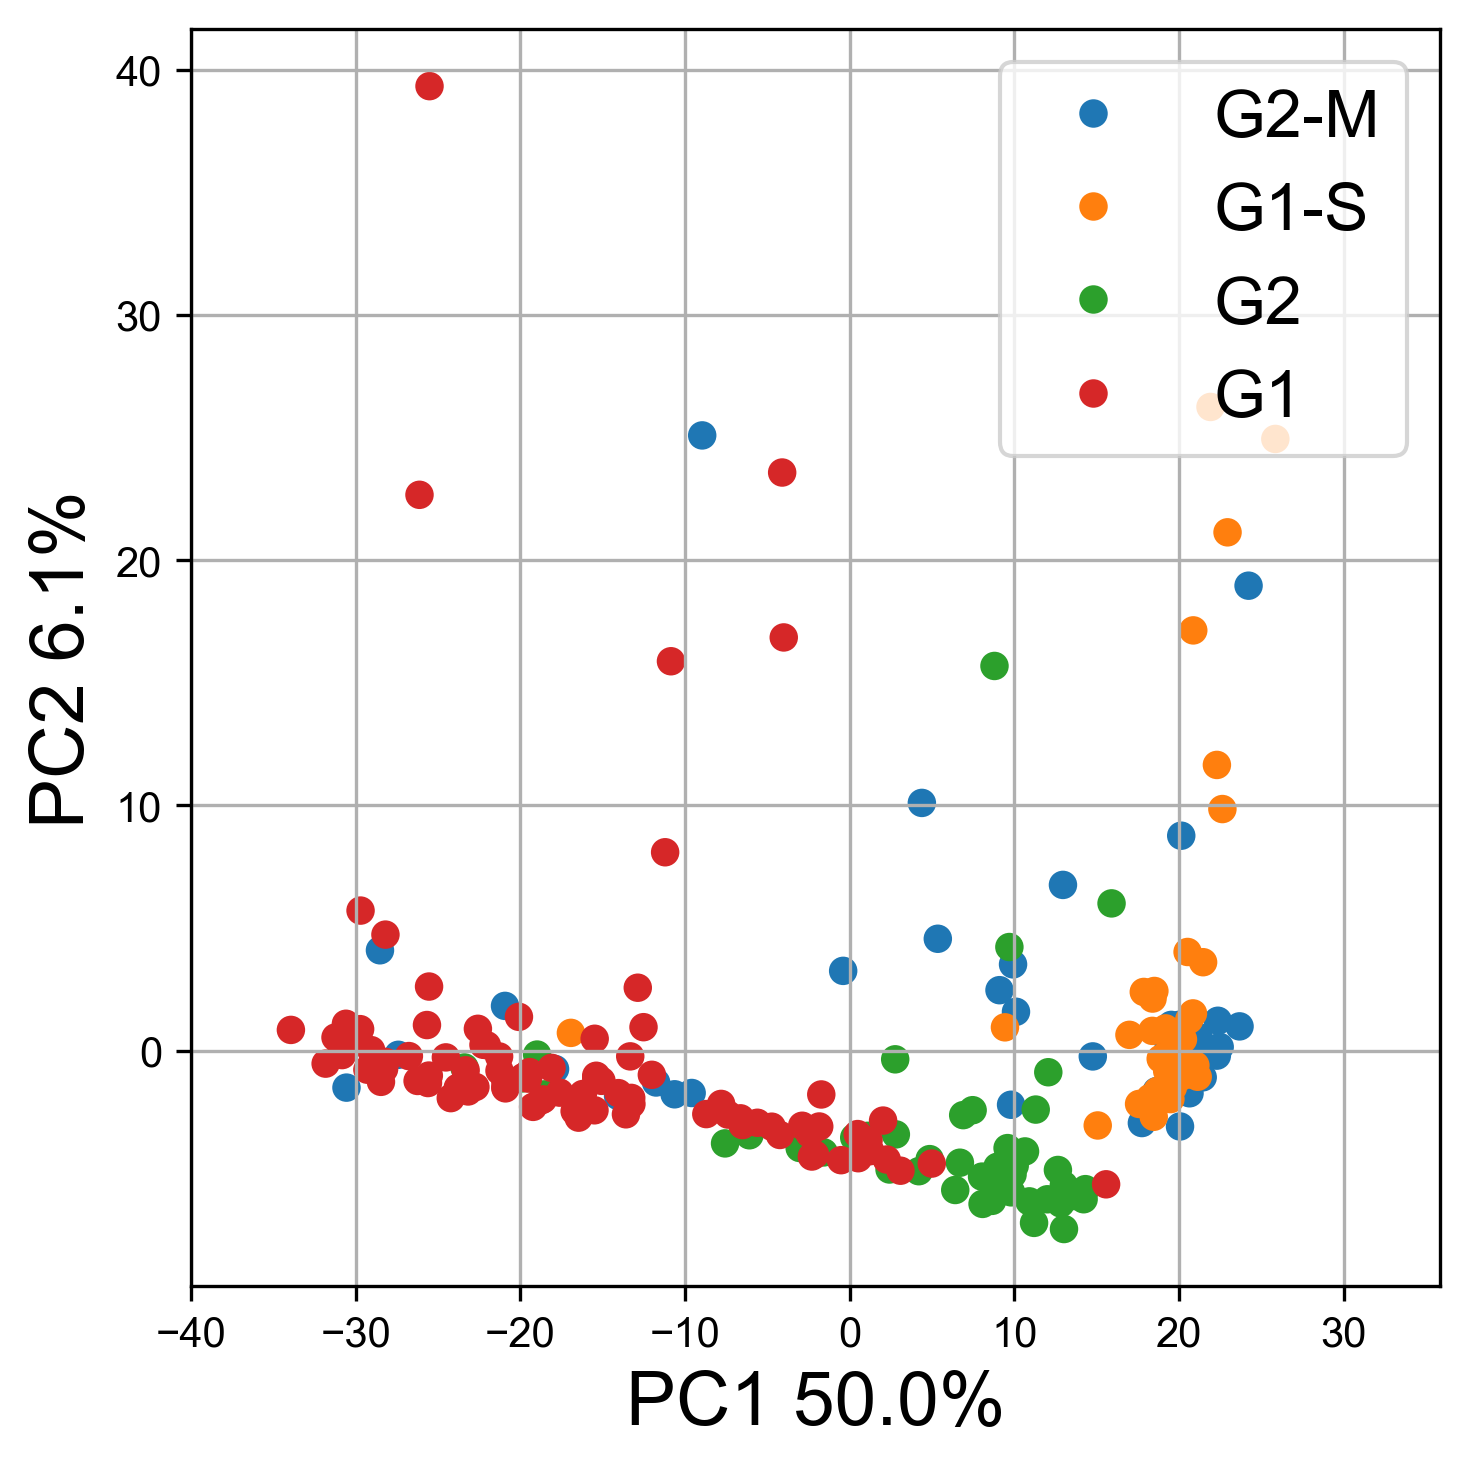

In [10]:
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

data = df_sample[cols_pg].values
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

score = silhouette_score(X_pca, df_sample['treat_id'], metric='euclidean')
print(f"silhouette score: {score:.4f}")

df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'treat_id': df_sample['treat_id'].values
})

plt.figure(figsize=(5, 5))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='treat_id', data=df_plot,
    s=40,
    edgecolor=None
)
ax.set_xlabel(f'PC1 {pca.explained_variance_ratio_[0] * 100:.1f}%',
              fontsize=18)
ax.set_ylabel(f'PC2 {pca.explained_variance_ratio_[1] * 100:.1f}%',
              fontsize=18)
ax.set_xlim(-40, df_plot['PC1'].max() + 10)
ax.set_ylim(None, None)
ax.grid(True)
plt.legend(title=None, fontsize=16, loc='upper right')
plt.tight_layout()
plt.show()

#### Differential Expression
- G2-M (treat group) vs. G1-S (control group)
- DEP calculation
- Volcano plot

In [11]:
df_sample = df_sample[df_sample['treat_id'].isin(['G1-S', 'G2-M'])].reset_index(drop=True)
n_g2m = sum(df_sample.treat_id == 'G2-M')
n_g1s = sum(df_sample.treat_id == 'G1-S')
print(f'G2-M #cells: {n_g2m}, G1-S #cells: {n_g1s}')
df_sample.copy()

G2-M #cells: 45, G1-S #cells: 41


,treat_id,sample_id,Q9Y6K9,Q9Y6K1,Q9Y6G9,Q9Y6E2,Q9Y6E0,Q9Y6B6,Q9Y6A9,Q9Y6A5,...,O00139,O00116,L0R819,E9PRG8,A6NHQ2,A6NDG6,A5YKK6,A5A3E0,A1X283,A0AVT1
0,G2-M,sample_3873,2.127749,2.610223,1.287467,2.296727,1.446317,0.877470,2.345567,0.805727,...,0.939042,2.209377,2.103602,1.291717,2.550194,2.151911,2.097658,6.009151,2.140598,2.132211
1,G2-M,sample_3874,0.804261,2.134273,1.165383,2.089299,1.482577,0.650896,2.053726,0.612674,...,0.659348,1.305557,0.197925,0.891339,2.455790,1.099786,0.701855,6.866469,1.018485,1.223193
2,G2-M,sample_3875,1.662293,2.050163,1.095720,2.067497,1.441601,1.582145,2.170105,1.895167,...,1.524800,1.426664,1.651376,1.348274,2.811681,1.093718,0.797155,6.669624,1.673370,1.040711
3,G2-M,sample_3876,0.440220,2.244925,1.347332,1.832972,1.952931,0.985921,1.388815,1.302058,...,0.486397,1.786712,1.162255,0.928827,2.830788,1.149913,0.589496,6.980355,0.704134,0.889741
4,G2-M,sample_3877,0.637032,2.164334,1.453453,1.784029,1.137411,0.868536,1.826096,1.408549,...,0.497516,1.174441,0.581819,1.084603,2.430504,1.268106,0.468139,6.780360,1.355647,0.974317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,G1-S,sample_4077,0.903057,2.284456,1.548559,2.279524,1.578941,1.632335,1.758361,1.147672,...,0.639095,1.566575,1.177927,1.522683,3.519513,1.307919,0.550964,4.650409,1.189524,1.004957
82,G1-S,sample_4080,0.746172,2.115976,1.255805,1.577176,1.448568,1.140035,1.818845,1.124426,...,0.569544,1.321443,0.955677,0.690474,3.251162,1.266572,0.609950,4.907422,0.828848,1.167935
83,G1-S,sample_4083,0.885792,2.171152,1.125965,2.188835,1.584461,0.711963,1.883869,1.104350,...,0.053800,1.465576,0.602473,0.698064,3.316267,0.827558,0.616499,4.721628,0.865912,1.150815
84,G1-S,sample_4086,0.859346,2.131588,1.551817,2.059945,1.359036,0.970478,1.356503,0.581579,...,0.580073,1.534797,0.678858,0.937251,3.229733,1.028152,0.662148,5.216871,0.930428,0.993500


In [12]:
# calculating: p, adj p, fc
from scipy import stats
import statsmodels.stats.multitest

pvalues = []
protein_names = []
mean_0_v, mean_1_v = [], []
for pg in cols_pg:
    x_treat = df_sample.loc[df_sample.treat_id == 'G2-M', pg].values
    x_control = df_sample.loc[df_sample.treat_id == 'G1-S', pg].values
    t_val, p_val = stats.ttest_ind(x_treat, x_control, equal_var=False)
    mean_0_v.append(np.mean(x_treat))
    mean_1_v.append(np.mean(x_control))
    pvalues.append(np.float32(p_val))
    protein_names.append(pg)
df_dep = pd.DataFrame({
    'protein_id': protein_names,
    'mean_treat': mean_0_v,
    'mean_control': mean_1_v,
    'pval': pvalues
})
df_dep['pval'] = df_dep['pval'].fillna(np.float32(1))
_, adj_pvals, _, _ = statsmodels.stats.multitest.multipletests(
    df_dep['pval'], alpha=0.05, method="fdr_bh")
df_dep['adj_pval'] = adj_pvals
df_dep['log_fc'] = df_dep['mean_treat'] - df_dep['mean_control']
df_dep.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc
0,Q9Y6K9,1.122107,0.770696,0.001019,0.005469,0.351411
1,Q9Y6K1,2.267390,1.935721,0.005627,0.016592,0.331669
2,Q9Y6G9,1.523506,1.372526,0.028509,0.056957,0.150980
3,Q9Y6E2,2.053230,1.872230,0.034536,0.065856,0.181000
4,Q9Y6E0,1.554977,1.364011,0.005466,0.016344,0.190966
...,...,...,...,...,...,...
1879,A6NDG6,1.215144,1.102870,0.153931,0.219369,0.112275
1880,A5YKK6,1.045248,0.641749,0.000448,0.003012,0.403500
1881,A5A3E0,5.216558,5.732725,0.091432,0.144148,-0.516167
1882,A1X283,1.220584,0.870560,0.001672,0.007498,0.350024


In [13]:
# assign up and down
cut_fc, cut_p = 0.2, 0.05
df_dep['state'] = 'none'
idx_up = (df_dep['log_fc'] > cut_fc) & (df_dep['adj_pval'] < cut_p)
idx_down = (df_dep['log_fc'] < -cut_fc) & (df_dep['adj_pval'] < cut_p)
df_dep.loc[idx_up, 'state'] = 'up'
df_dep.loc[idx_down, 'state'] = 'down'
n_neg = sum(df_dep['log_fc'] < 0)
n_pos = sum(df_dep['log_fc'] > 0)
n_down = sum(df_dep['state'] == 'down')
n_up = sum(df_dep['state'] == 'up')
print(f'left area: {n_down}/{n_neg}, right area: {n_up}/{n_pos}')
df_dep.copy()

left area: 150/523, right area: 702/1361


,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state
0,Q9Y6K9,1.122107,0.770696,0.001019,0.005469,0.351411,up
1,Q9Y6K1,2.267390,1.935721,0.005627,0.016592,0.331669,up
2,Q9Y6G9,1.523506,1.372526,0.028509,0.056957,0.150980,none
3,Q9Y6E2,2.053230,1.872230,0.034536,0.065856,0.181000,none
4,Q9Y6E0,1.554977,1.364011,0.005466,0.016344,0.190966,none
...,...,...,...,...,...,...,...
1879,A6NDG6,1.215144,1.102870,0.153931,0.219369,0.112275,none
1880,A5YKK6,1.045248,0.641749,0.000448,0.003012,0.403500,up
1881,A5A3E0,5.216558,5.732725,0.091432,0.144148,-0.516167,none
1882,A1X283,1.220584,0.870560,0.001672,0.007498,0.350024,up


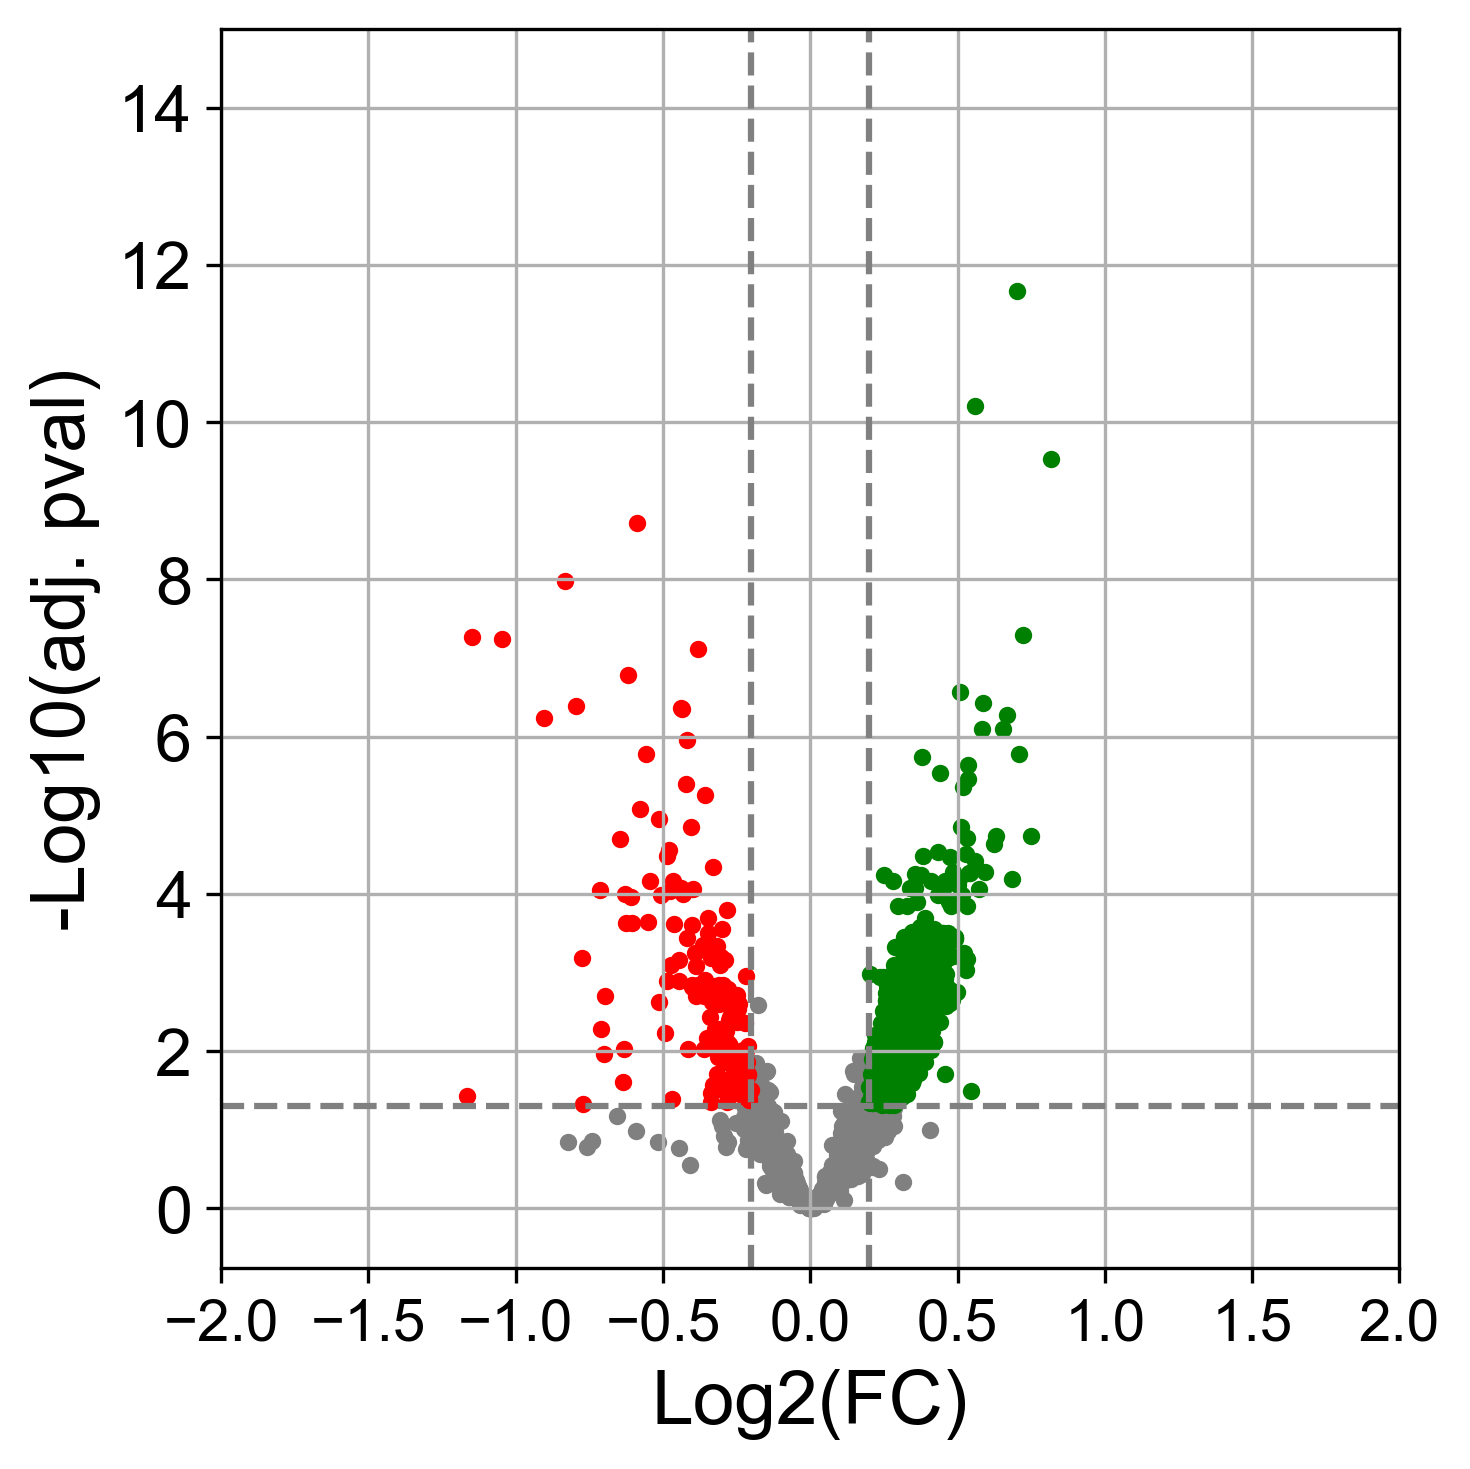

In [14]:
# valcano plot
df_dep['Y'] = -np.log10(df_dep['adj_pval'])
plt.figure(figsize=(5, 5))

df_none = df_dep[df_dep['state'] == 'none']
plt.scatter(x=df_none['log_fc'],
            y=df_none['Y'],
            s=10, label="Not significant", color='grey')

df_up = df_dep[df_dep['state'] == 'up']
df_down = df_dep[df_dep['state'] == 'down']
plt.scatter(x=df_down['log_fc'],
            y=df_down['Y'],
            s=10, color="red")
plt.scatter(x=df_up['log_fc'],
            y=df_up['Y'],
            s=10, color="green")

plt.axvline(cut_fc, color="grey", linestyle="--")
plt.axvline(-cut_fc, color="grey", linestyle="--")
plt.axhline(-np.log10(cut_p), color="grey", linestyle="--")

plt.ylabel("-Log10(adj. pval)", fontsize=18)
plt.xlabel("Log2(FC)", fontsize=18)
plt.xticks(fontweight='light', fontsize=14)
plt.yticks(fontweight='light', fontsize=16)

plt.grid(True)
plt.xlim(-2, 2)
plt.ylim(None, 15)
plt.tight_layout()
plt.show()

#### Pathway Analysis

In [15]:
# pg --> gene
protein_ids, gene_names, is_isoforms = [], [], []
with open(report_dir/'meta'/'swissprot_UP5640_human_20420_20240619.fasta', 'r') as fasta_file:
    for line in fasta_file:
        line = line.strip()
        if line.startswith(">"):
            protein_id = line.split('|')[1]
            gene_name = None
            for field in line.split():
                if field.startswith("GN="):
                    gene_name = field.split("=")[1]
                    break
            protein_ids.append(protein_id)
            gene_names.append(gene_name)
            is_isoforms.append(line.__contains__('isoform'))
df_map = pd.DataFrame({
    "protein_id": protein_ids, "gene": gene_names
})
df_map = df_map.dropna().reset_index(drop=True)
df_gene = pd.merge(df_dep, df_map, on='protein_id')
df_gene.copy()

,protein_id,mean_treat,mean_control,pval,adj_pval,log_fc,state,Y,gene
0,Q9Y6K9,1.122107,0.770696,0.001019,0.005469,0.351411,up,2.262104,IKBKG
1,Q9Y6K1,2.267390,1.935721,0.005627,0.016592,0.331669,up,1.780111,DNMT3A
2,Q9Y6G9,1.523506,1.372526,0.028509,0.056957,0.150980,none,1.244454,DYNC1LI1
3,Q9Y6E2,2.053230,1.872230,0.034536,0.065856,0.181000,none,1.181406,BZW2
4,Q9Y6E0,1.554977,1.364011,0.005466,0.016344,0.190966,none,1.786644,STK24
...,...,...,...,...,...,...,...,...,...
1879,A6NDG6,1.215144,1.102870,0.153931,0.219369,0.112275,none,0.658824,PGP
1880,A5YKK6,1.045248,0.641749,0.000448,0.003012,0.403500,up,2.521125,CNOT1
1881,A5A3E0,5.216558,5.732725,0.091432,0.144148,-0.516167,none,0.841190,POTEF
1882,A1X283,1.220584,0.870560,0.001672,0.007498,0.350024,up,2.125041,SH3PXD2B


Interactions Of Vpr With Host Cellular Proteins;Metabolism Of RNA;Processing Of Capped Intron-Containing Pre-mRNA;Vpr-mediated Nuclear Import Of PICs;Transport Of SLBP Independent Mature mRNA;Rev-mediated Nuclear Export Of HIV RNA;Defective TPR May Confer Susceptibility Towards Thyroid Papillary Carcinoma (TPC);Transport Of SLBP Dependant Mature mRNA;Interactions Of Rev With Host Cellular Proteins;NS1 Mediated Effects On Host Pathways;Nuclear Import Of Rev Protein;Transport Of Ribonucleoproteins Into Host Nucleus;SUMOylation Of SUMOylation Proteins;NEP/NS2 Interacts With Cellular Export Machinery;Transport Of Mature mRNA Derived From An Intron-Containing Transcript


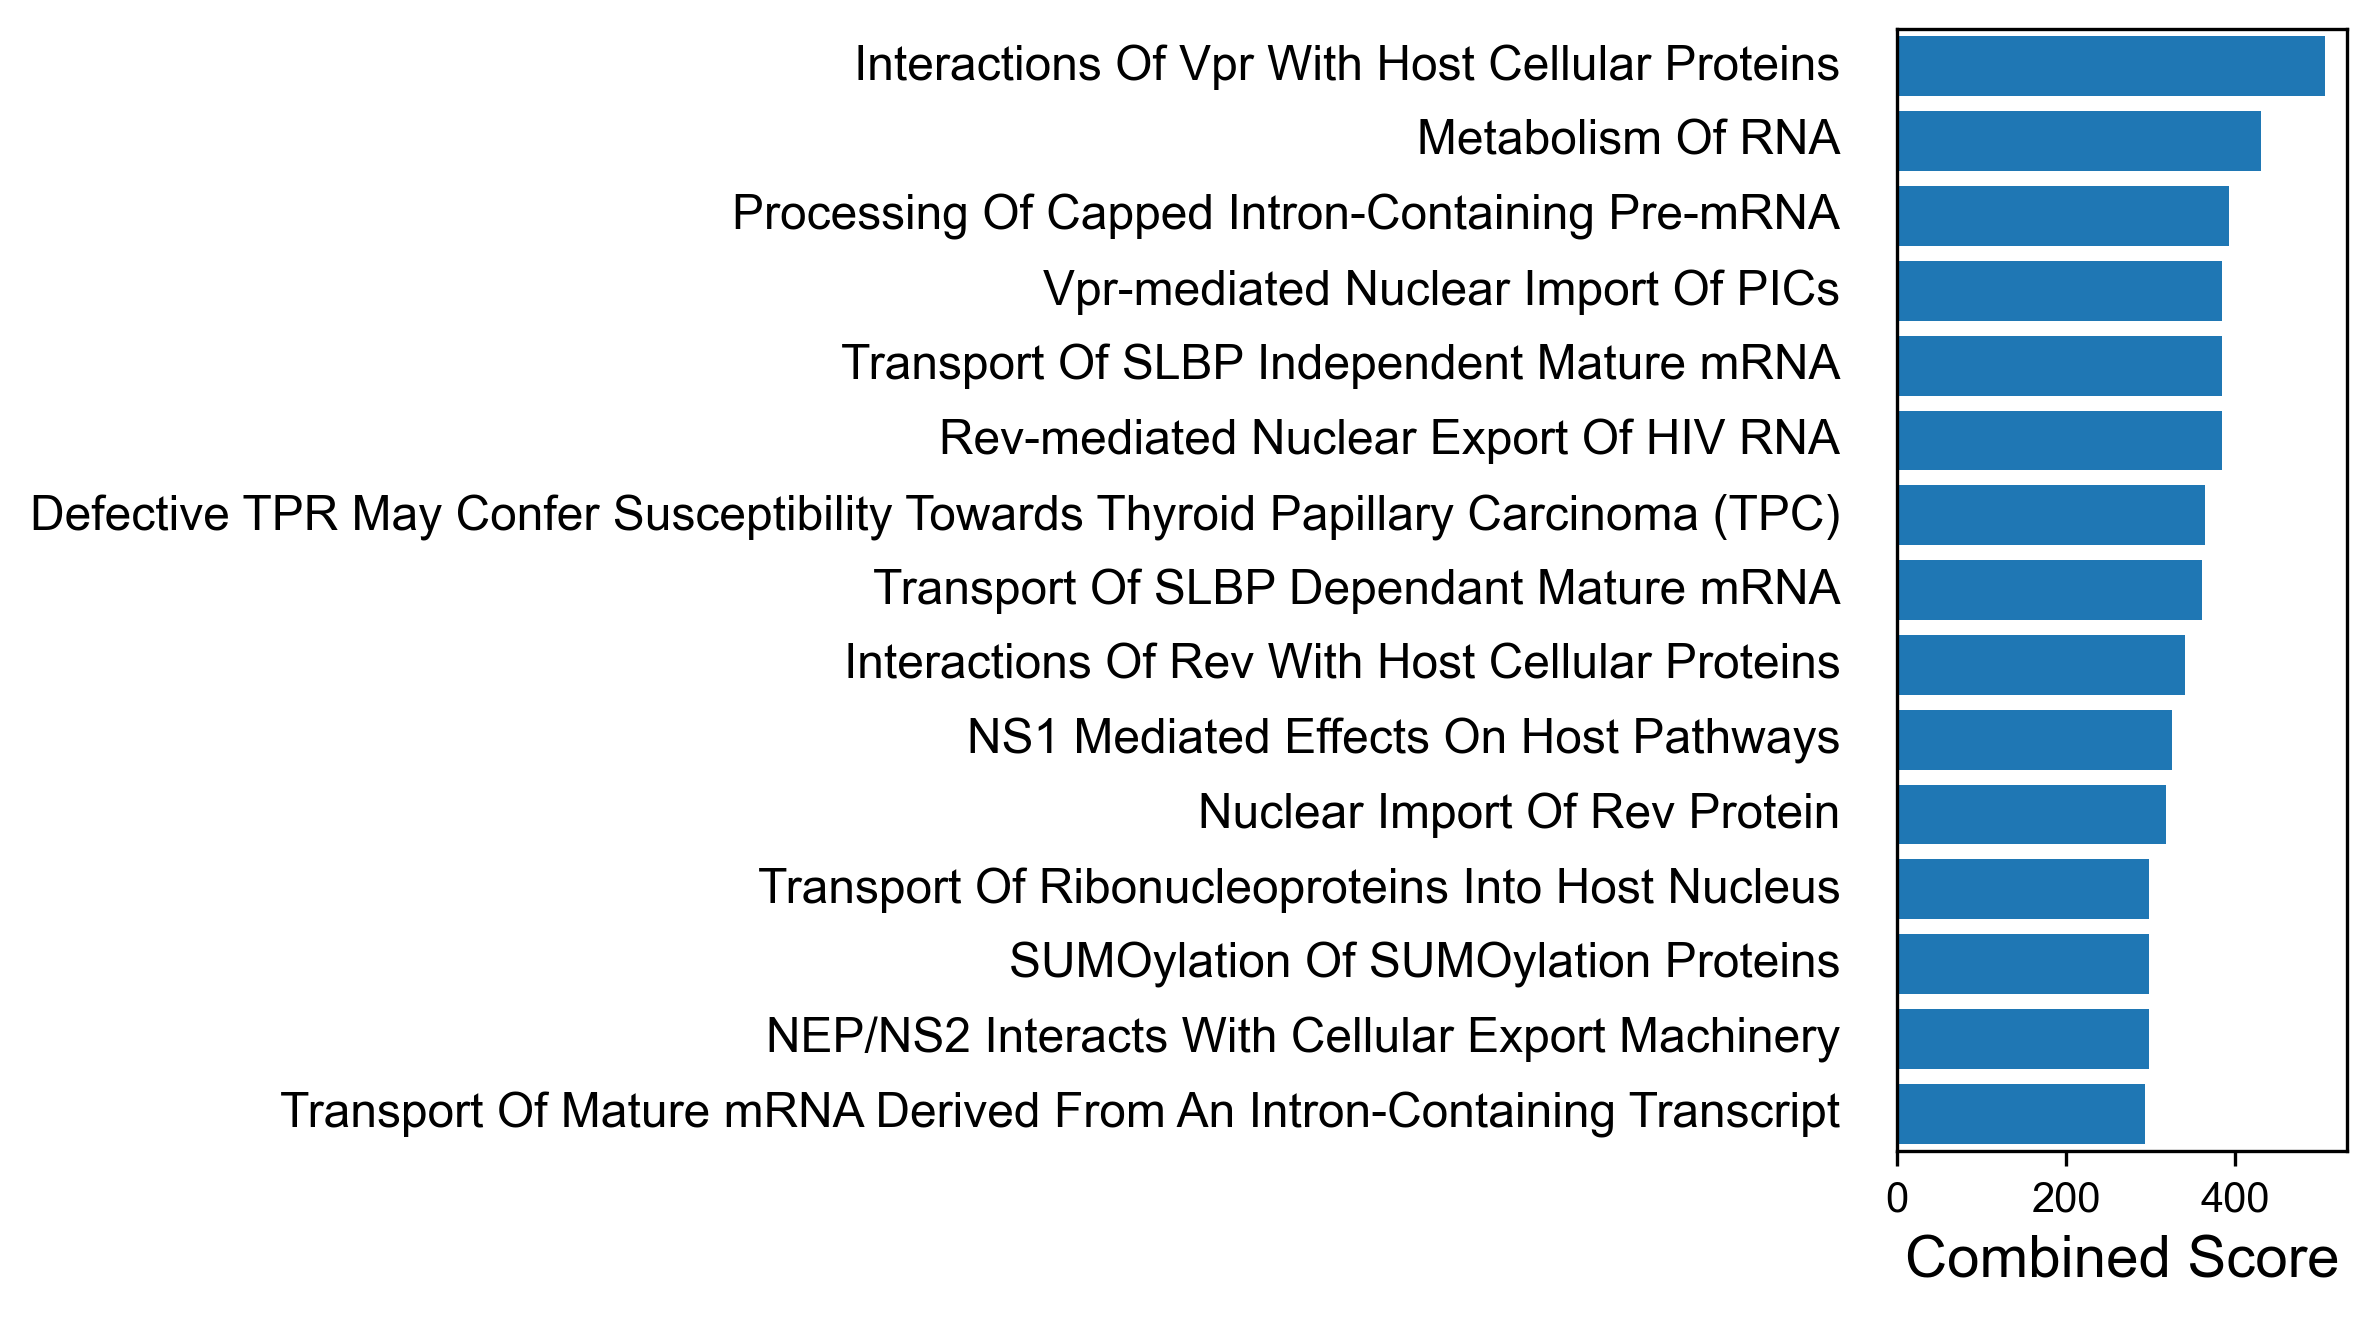

In [16]:
# up pathway enrichment plot
import gseapy as gp
import matplotlib.gridspec as gridspec

n_path = 15

ups = set(df_gene[df_gene['state'] == 'up']['gene'])
enr = gp.enrichr(gene_list=list(ups),
                 gene_sets='Reactome_2022',
                 organism='Human',
                 outdir=None)
df_path = enr.results
df_path = df_path[df_path['Adjusted P-value'] < cut_p]
df_path = df_path.nlargest(n_path, 'Combined Score')

df_path['Term'] = df_path['Term'].str.split(' R-HSA-').str[0]
df_path = df_path.sort_values('Combined Score', ascending=True)
print(df_path['Term'][::-1].str.cat(sep=';'))

terms = df_path['Term'].astype(str).tolist()
scores = df_path['Combined Score'].tolist()
y_pos = np.arange(len(terms))

fig = plt.figure(figsize=(7.5, 4.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1.5])

# Left for terms
ax_text = plt.subplot(gs[0])
ax_text.set_xlim(0, 1)
ax_text.set_ylim(-0.5, len(terms) - 0.5)
ax_text.axis('off')
for i, term in enumerate(terms):
    ax_text.text(1.0, i, term, va='center', ha='right', fontsize=11.5)

# Right for scores
ax_bar = plt.subplot(gs[1])
ax_bar.barh(y_pos, scores)
ax_bar.set_yticks([])
ax_bar.set_ylim(-0.5, len(terms) - 0.5)
ax_bar.set_xlabel('Combined Score', fontsize=14)

plt.tight_layout()
plt.show()